In [27]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets

## 1: Set up the historical data which will be used for the Priors

In [28]:
# Number of states and parties
NUM_STATES = 16
NUM_PARTIES = 8
STATES = ["BW", "BY", "BE", "BB", "HB", "HH", "HE", "MV", "NI", "NW", "RP", "SL", "SN", "ST", "SH", "TH"]

In [29]:
# set random seed
np.random.seed(41)

One issue is that BSW will appear the first time in the election 2025. This already implies that I cannot rely soley on historical election data.

In [30]:
# Voter share for the whole nation 2021 (8 Parties)
historical_shares_nation = np.array([0.241, 0.257, 0.148, 0.115, 0.049, 0.103, 0.000, 0.087])

In [31]:
def get_poll_data(cutoff_date: str, bundestag: bool):
    # Include Polls from 7th of November -> Time when the coalition did break apart
    poll_df = pd.read_csv("/home/juliusd/documents/Quant-Econ/Bayesian_Modelling/Term_paper/Resources_all/Polls/output.csv")

    # Filter for the 7th of November and relevant columns
    poll_df = poll_df[poll_df['survey_date'] >= cutoff_date]
    relevant_cols = ["survey_date", "survey_persons", "parliament_id", "institute_id", "result_cdu-csu", "result_spd", "result_gruene",
                    "result_fdp", "result_linke", "result_afd", "result_bsw", "result_sonstige", "result_cdu", "result_csu"]
    poll_df = poll_df[relevant_cols]

    # Add results of cdu and csu in cdu-csu
    poll_df['result_cdu-csu'] = poll_df['result_cdu-csu'].fillna(0) + poll_df['result_cdu'].fillna(0) + poll_df['result_csu'].fillna(0)
    poll_df = poll_df.drop(columns=['result_cdu', 'result_csu'])

    # Only consider polls for bundestag
    if bundestag:
        poll_df = poll_df[poll_df['parliament_id'] == "bundestag"]
    else:
        poll_df = poll_df[poll_df['parliament_id'] != "bundestag"]
    # Drop prefix result_ from column names
    poll_df.columns = poll_df.columns.str.replace('result_', '')

    return poll_df

Get poll data 6 months from the actual election until I start collecting polls for multinomial likelihood (07.11.24). These polls will be combined with the past election result as prior

In [32]:
baseline_polls = get_poll_data("2024-08-23", True)
baseline_polls = baseline_polls[baseline_polls['survey_date'] < "2024-11-07"]
baseline_polls = baseline_polls.drop(columns=['survey_date', 'survey_persons', 'parliament_id', 'institute_id'])
# avergae over all polls
baseline_polls = baseline_polls.mean() / 100
# round and convert to numpy array
baseline_polls = baseline_polls.round(3)
baseline_polls = baseline_polls.to_numpy()

In [33]:
# Average last election result and baseline polls
voter_shares_nation = (historical_shares_nation + baseline_polls)

### Dirichlet Regression
Discuss this as a potential addition to the model.

In [34]:
# Set alpha parameter for dirichlet distribution of prior
a_nation = voter_shares_nation * 100

## 2. Including the Poll Data

In [35]:
nation_polls = get_poll_data("2024-11-07", True)
# Only include last 5 polls
nation_polls = nation_polls[0:5]
print(nation_polls)

  survey_date  survey_persons parliament_id             institute_id  cdu-csu  \
0  2025-02-21            1681     bundestag                   yougov     29.0   
1  2025-02-20            1349     bundestag  forschungsgruppe-wahlen     28.0   
2  2025-02-20            2000     bundestag                    ipsos     31.0   
4  2025-02-20            2502     bundestag                     insa     30.0   
6  2025-02-19            1016     bundestag                      gms     31.0   

    spd  gruene  fdp  linke   afd  bsw  sonstige  
0  16.0    13.0  4.0    8.0  20.0  5.0       5.0  
1  16.0    14.0  4.5    8.0  21.0  4.5       4.0  
2  15.0    13.0  4.5    7.0  20.0  4.5       5.0  
4  15.0    13.0  4.0    7.0  21.0  5.0       5.0  
6  15.0    13.0  4.0    6.0  20.0  4.0       5.0  


Create weights for the polls, IDEA: Later polls are more important.
Use a decay function so that polls lose weight over time.

In [36]:
def assign_weights_to_polls(national_polls: pd.DataFrame):
    # Define decay rate
    half_life = 30  # Poll looses half of its weight every 30 days
    decay_rate = np.log(2) / half_life

    # Convert survey_date to datetime format
    national_polls['survey_date'] = pd.to_datetime(national_polls['survey_date'])

    # Compute weights based on poll dates
    poll_dates = np.array(national_polls['survey_date'], dtype="datetime64[D]")
    earliest_poll_date = np.max(poll_dates)  
    time_diffs = (earliest_poll_date - poll_dates).astype("timedelta64[D]").astype(int)  # Days since each poll
    weights = np.exp(-decay_rate * time_diffs)  # Exponential decay

    return weights

In [37]:
for var in ["cdu-csu", "spd", "gruene", "fdp", "linke", "afd", "bsw", "sonstige"]:
    nation_polls[var] = round(nation_polls["survey_persons"] * nation_polls[var] / 100)

# Get weights for each poll
weights = assign_weights_to_polls(nation_polls)
# Drop unnecessary columns
nation_polls = nation_polls.drop(columns=["survey_persons", "institute_id", "survey_date", "parliament_id"])

# Data processing and then store it in lists
nation_polls = nation_polls.fillna(0)
nation_polls.reset_index(drop=True, inplace=True)
survey_results_nation = nation_polls.values.tolist()
sample_size_nation = nation_polls.sum(axis=1).to_list()


## 3: Building the Bayesian Model using PyMC

In [38]:
SCALER = 0.1
# Weight the national polls with exponential decay
survey_results_nation_adj = []
for i in range(len(survey_results_nation)):
    adjusted_shares = [round(weights[i] * voter_share * SCALER) for voter_share in survey_results_nation[i]]
    survey_results_nation_adj.append(adjusted_shares)

sample_size_nation_adj = [sum(adjusted_shares) for adjusted_shares in survey_results_nation_adj]

In [39]:
with pm.Model() as nation_model:
    # Quantify uncertainty in historical results and early polls for the prior by gamma distribution
    alpha_nation = pm.Gamma("alpha_nation", alpha=a_nation, beta=2, shape=8)    
    # Dirichlet-Prior
    nation_prior = pm.Dirichlet("voter_share_nation", a=alpha_nation, shape=(NUM_PARTIES,))

    # National level likelihood based on poll results
    # NOTE: For observed I use a list comprehension to multiply each party's voter share by the corresponding weight
    for i in range(len(survey_results_nation)):
        nation_likelihood = pm.Multinomial(
            f"nation_poll_{i}", 
            n=sample_size_nation_adj[i], 
            p=nation_prior, 
            observed=survey_results_nation_adj[i]
        )

## 4: Sampling from the posterior

In [40]:
with nation_model:
    trace = pm.sample(
        draws=10000,
        chains=4,
        random_seed=42,
        return_inferencedata=True
        )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [alpha_nation, voter_share_nation]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 103 seconds.


## 5: Analyzing the results

In [41]:
# summarize 
summary = az.summary(trace, hdi_prob=0.9)
summary.to_csv("/home/juliusd/documents/Quant-Econ/Bayesian_Modelling/Term_paper/results/Final/5poll_model.csv")

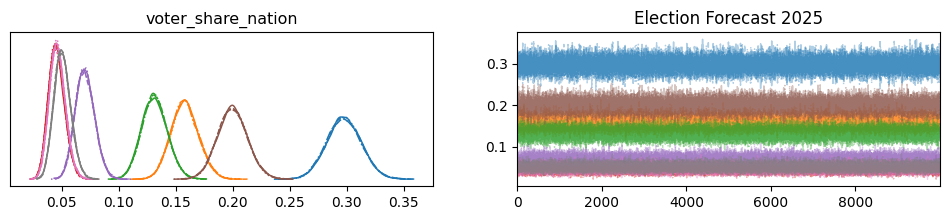

In [42]:
# 5: Analyzing the results
# If I get the colors to represent the parties, use this list
party_colors = ['black', 'red', 'green', 'yellow', 'pink', 'blue', 'purple', 'grey']
party_labels = ['CDU', 'SPD', 'Greens', 'FDP', 'Left', 'AfD', 'BSW', 'Others']

# Plot trace for national posterior
az.plot_trace(trace, var_names=["voter_share_nation"])
plt.title("Election Forecast 2025")
plt.show()

## Prediction for the Election
For the Non-Bayesian, in the following there will be a more classical summary of the posterior. Not as meaningful as the posteriors and traces above, but maybe more intuitive to understand for some 😃

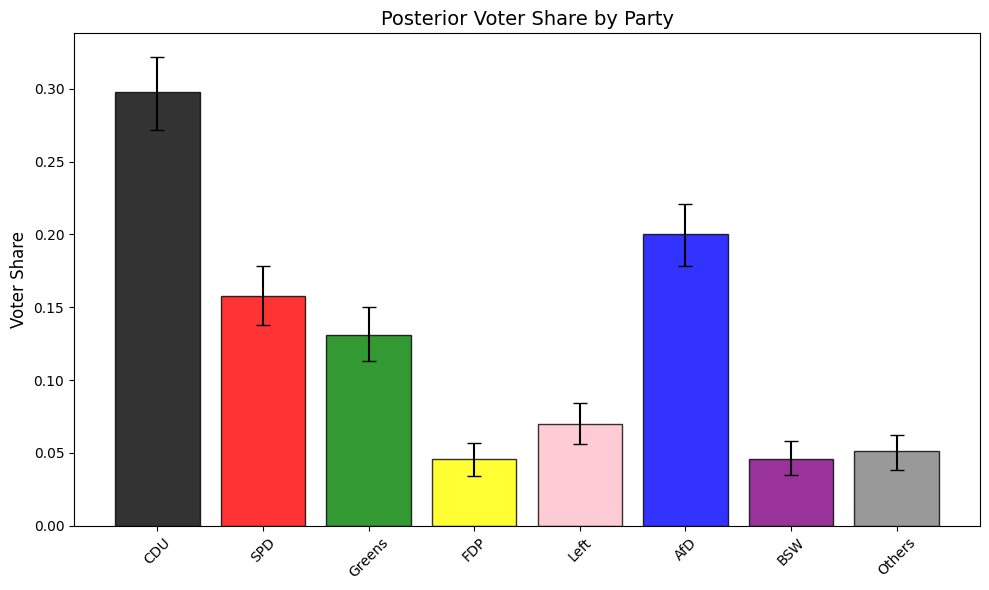

In [43]:
summary_nation = az.summary(trace, var_names=["voter_share_nation"], hdi_prob=0.90)
# create bar plot for mean values and uncertainty, suing the party colors
# Bar plot with error bars
means = summary_nation["mean"].to_list()
hdi_lower = summary_nation["hdi_5%"].to_list()
hdi_upper = summary_nation["hdi_95%"].to_list()
x = np.arange(len(means))
plt.figure(figsize=(10, 6))
plt.bar(x, means, yerr=[np.array(means) - np.array(hdi_lower), np.array(hdi_upper) - np.array(means)], 
        color=party_colors, capsize=5, alpha=0.8, edgecolor='black')
plt.xticks(x, party_labels, rotation=45, fontsize=10)
plt.ylabel('Voter Share', fontsize=12)
plt.title('Posterior Voter Share by Party', fontsize=14)
plt.tight_layout()
plt.show()

### Inspect the model used to create forecast

In [44]:
nation_model

      alpha_nation ~ Gamma(<constant>, f())
voter_share_nation ~ Dirichlet(alpha_nation)
     nation_poll_0 ~ Multinomial(168, voter_share_nation)
     nation_poll_1 ~ Multinomial(132, voter_share_nation)
     nation_poll_2 ~ Multinomial(196, voter_share_nation)
     nation_poll_3 ~ Multinomial(244, voter_share_nation)
     nation_poll_4 ~ Multinomial(96, voter_share_nation)